# Emotion-Aware Journaling — Text Emotion Training Notebook

This notebook trains a **Text Emotion Classifier** using the GoEmotions dataset:
- **Model**: `Roberta` fine-tuning for emotion classification
- **Dataset**: GoEmotions with 28 emotion labels
- **Optimization**: Mixed precision training, class weighting, learning rate warmup
- **Output**: Model saved and export for backend integration

## Training Pipeline:
1) Setup and Import Libraries
2) Data loading and Multi-label Setup
3) Exploratory Data Analysis (EDA)
4) Data Preprocessing and Tokenization 
5) Model building and Training Setup
6) Model Training
7) Model Evaluation and Testing
8) Threshold Tuning on Validation Set
9) Final Test Evaluation with Tuned Thresholds
10) Lightweight Hyperparameter Search (Validation Micro F1)
11) Export Model & Thresholds
12) ONNX Export & Verification


## 1) Setup and import libraries

### 1.1) Import libraries

In [22]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

from transformers.trainer_utils import IntervalStrategy 
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    hamming_loss,
    jaccard_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
 )
from tqdm.auto import tqdm  
notebook_tqdm = tqdm  

### 1.2) Set device to GPU if available

In [2]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU Name: NVIDIA GeForce RTX 3060 Laptop GPU


### 1.3) Define the model checkpoint

In [3]:
# Define the model checkpoint
MODEL_CHECKPOINT = "roberta-base"

## 2) Data Loading and Multi-Label Setup

### 2.1) Loading of go_emotions dataset

In [4]:
# load the 'go_emotions' dataset, which requires special handling as it is multi-label.

try:
    # Load the full go_emotions dataset (using default configuration which is multi-label)
    raw_datasets = load_dataset("go_emotions", "simplified")
    print("GoEmotions dataset loaded successfully.")
except Exception as e:
    print(f"Could not load dataset: {e}. Falling back to a small subset.")
    # Fallback for demonstration purposes
    raw_datasets = DatasetDict({
        'train': load_dataset('go_emotions', 'simplified', split='train[:1000]'),
        'validation': load_dataset('go_emotions', 'simplified', split='validation[:100]'),
        'test': load_dataset('go_emotions', 'simplified', split='test[:100]'),
    })

# Get label names and number of labels
label_names = raw_datasets['train'].features['labels'].feature.names
NUM_LABELS = len(label_names)
print(f"Number of classes: {NUM_LABELS}")

GoEmotions dataset loaded successfully.
Number of classes: 28


### 2.2) Convert to pandas DataFrames for easy EDA

In [5]:
# Convert to pandas DataFrames for easy EDA
train_df = raw_datasets['train'].to_pandas()
val_df = raw_datasets['validation'].to_pandas()
test_df = raw_datasets['test'].to_pandas()

# Display dataset info
print("\nDataset Structure (Note: 'labels' is a list of emotion indices):")
print(raw_datasets)
print("\nTraining Set Head:")
print(train_df.head())


Dataset Structure (Note: 'labels' is a list of emotion indices):
DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Training Set Head:
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj


## 3) Exploratory Data Analysis (EDA)

### 3.1) Multi-Label Class Distribution

Counting Labels:   0%|          | 0/43410 [00:00<?, ?it/s]

Counting Labels: 100%|██████████| 43410/43410 [00:00<00:00, 447241.59it/s]


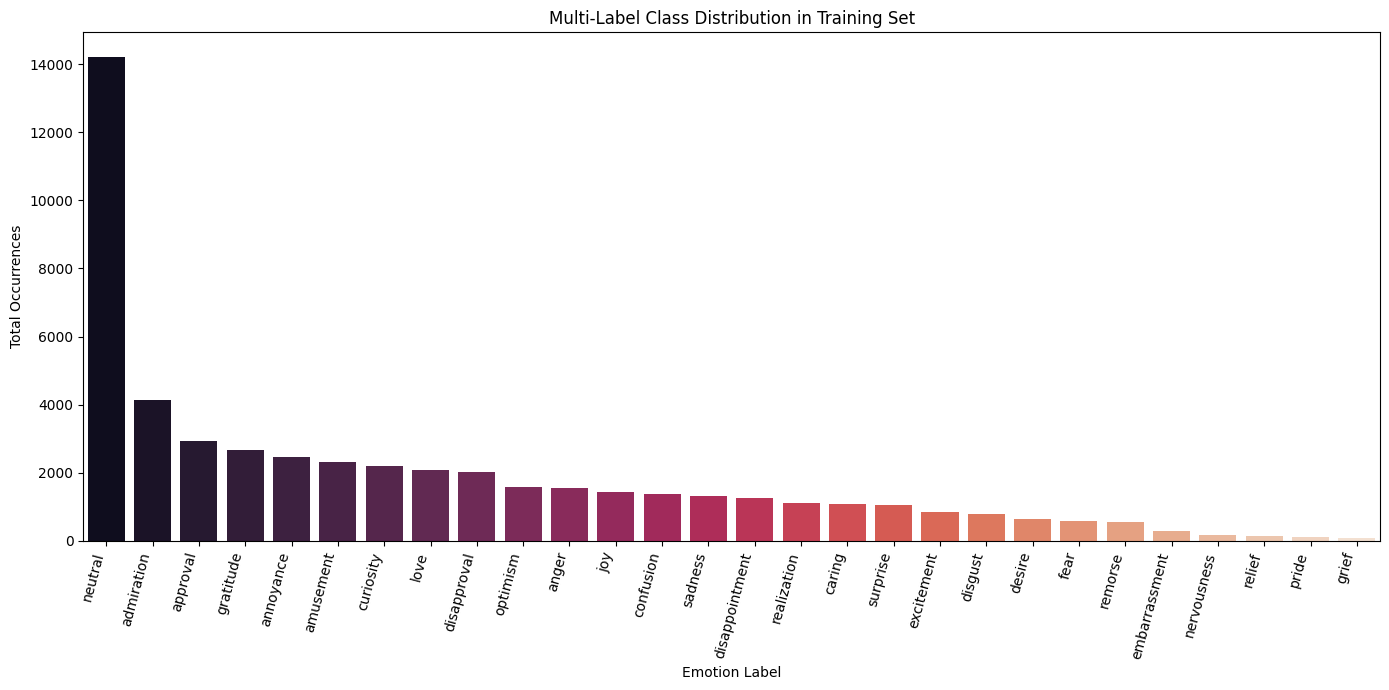

In [6]:
label_counts = {name: 0 for name in label_names}

# Count occurrences of each label across all samples
for label_list in tqdm(train_df['labels'], desc="Counting Labels"):
    for label_id in label_list:
        label_counts[label_names[label_id]] += 1

label_series = pd.Series(label_counts).sort_values(ascending=False)

# Convert Series into DataFrame for seaborn hue support
label_df = pd.DataFrame({
    "emotion": label_series.index,
    "count": label_series.values
})

plt.figure(figsize=(14, 7))
sns.barplot(
    data=label_df,
    x="emotion",
    y="count",
    hue="emotion",       # assign hue = x variable
    palette="rocket",
    dodge=False          # keeps bars centered
)

plt.legend([], [], frameon=False)  # hide long legend
plt.xticks(rotation=75, ha='right')
plt.title('Multi-Label Class Distribution in Training Set')
plt.xlabel('Emotion Label')
plt.ylabel('Total Occurrences')
plt.tight_layout()
plt.show()


### 3.2) Text Length Distribution

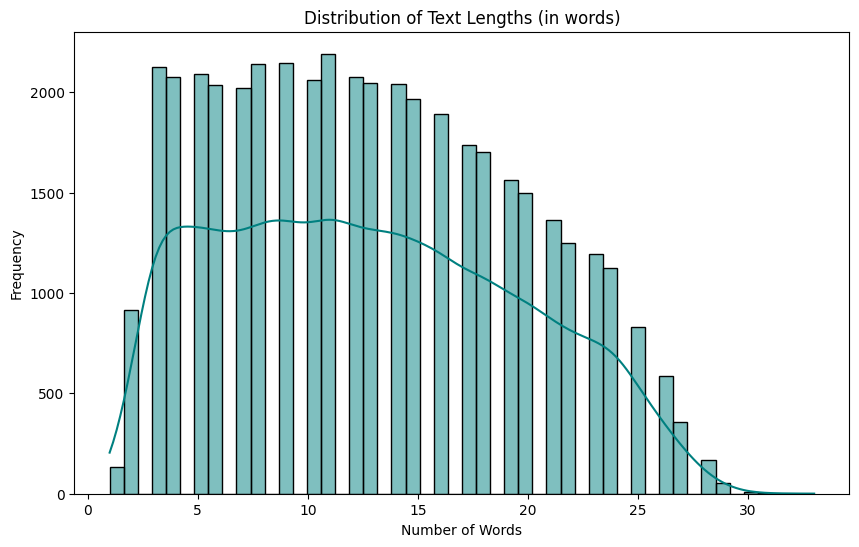

In [7]:
# Calculate text lengths
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True, color='teal')
plt.title('Distribution of Text Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### 3.3) Descriptive Statistics for text_length

In [8]:
# Summary statistics for text length
print("Text Length Summary (in words):")
print(train_df['text_length'].describe())

Text Length Summary (in words):
count    43410.000000
mean        12.840175
std          6.701597
min          1.000000
25%          7.000000
50%         12.000000
75%         18.000000
max         33.000000
Name: text_length, dtype: float64


In [9]:
# Set maximum sequence length based on distribution
MAX_LENGTH = 160

### 3.4) Dataset Integrity Checks (Missing values, duplicates, and basic sanity)

These checks help ensure the training data is clean and consistent **before** any modelling. Run the cells below and inspect outputs carefully.


In [10]:
from IPython.display import display

# Missing values check
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape if 'test_df' in globals() else "test_df not loaded")

print("\nMissing values (train):")
display(train_df.isna().sum().sort_values(ascending=False).head(10))

# Empty / whitespace-only texts
empty_text_mask = train_df['text'].astype(str).str.strip().eq("")
print("\nEmpty texts:", int(empty_text_mask.sum()))

# Duplicate texts (exact duplicates)
dup_count = int(train_df['text'].duplicated().sum())
print("Duplicate texts (exact):", dup_count)

# Optional: view a few duplicates
if dup_count > 0:
    display(train_df.loc[train_df['text'].duplicated(keep=False), ['text','labels']].head(10))


Train shape: (43410, 4)
Validation shape: (5426, 3)
Test shape: (5427, 3)

Missing values (train):


text           0
labels         0
id             0
text_length    0
dtype: int64


Empty texts: 0
Duplicate texts (exact): 183


,text,labels
197,[NAME],[11]
283,Hi [NAME]!,[27]
333,I like it!,"[0, 4]"
603,oh my [NAME],[26]
651,Weird flex but okay,[27]
891,Anytime :),[27]
985,"Hi, [NAME]! I am stopping by to wish you the b...",[5]
991,What the hell,"[2, 3]"
995,I love [NAME],[18]
1030,"A surprise to be sure, but a welcome one.",[20]


### 3.5) Label Cardinality and Density

For multi-label emotion classification, two quick diagnostics are:
- **Cardinality:** average number of labels per sample
- **Density:** cardinality divided by number of possible labels

These influence loss choice, thresholding, and evaluation.


Labels per sample (train) summary:


count    43410.000000
mean         1.177217
std          0.417699
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          5.000000
Name: n_labels, dtype: float64

Num classes: 28
Label cardinality (avg labels/sample): 1.177
Label density (cardinality/num_classes): 0.04204


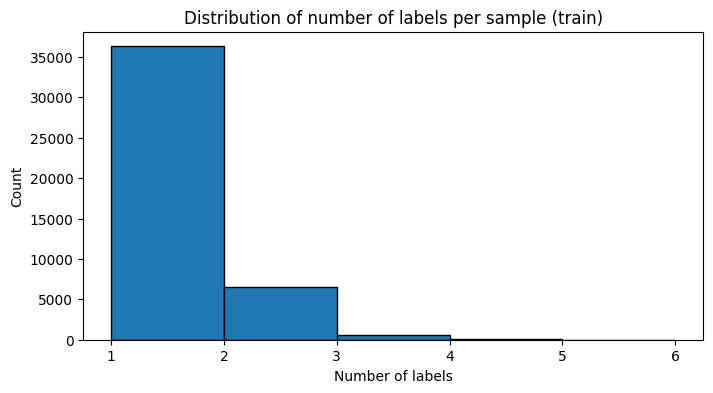

Single-label samples: 36308 (83.6%)
Multi-label samples: 7102 (16.4%)


In [11]:
# Number of labels per sample
train_df['n_labels'] = train_df['labels'].apply(len)

print("Labels per sample (train) summary:")
display(train_df['n_labels'].describe())

num_classes = len(label_names)
cardinality = train_df['n_labels'].mean()
density = cardinality / num_classes

print(f"Num classes: {num_classes}")
print(f"Label cardinality (avg labels/sample): {cardinality:.3f}")
print(f"Label density (cardinality/num_classes): {density:.5f}")

# Distribution plot
plt.figure(figsize=(8,4))
plt.hist(train_df['n_labels'], bins=range(1, train_df['n_labels'].max()+2), edgecolor='black')
plt.title("Distribution of number of labels per sample (train)")
plt.xlabel("Number of labels")
plt.ylabel("Count")
plt.show()

# How many are single-label vs multi-label?
single = int((train_df['n_labels'] == 1).sum())
multi = int((train_df['n_labels'] > 1).sum())
print(f"Single-label samples: {single} ({single/len(train_df):.1%})")
print(f"Multi-label samples: {multi} ({multi/len(train_df):.1%})")


### 3.6) Train vs Validation Distribution Checks

It’s useful to verify that the split does not accidentally shift distributions (e.g., train is much longer text than validation, or certain emotions are underrepresented).


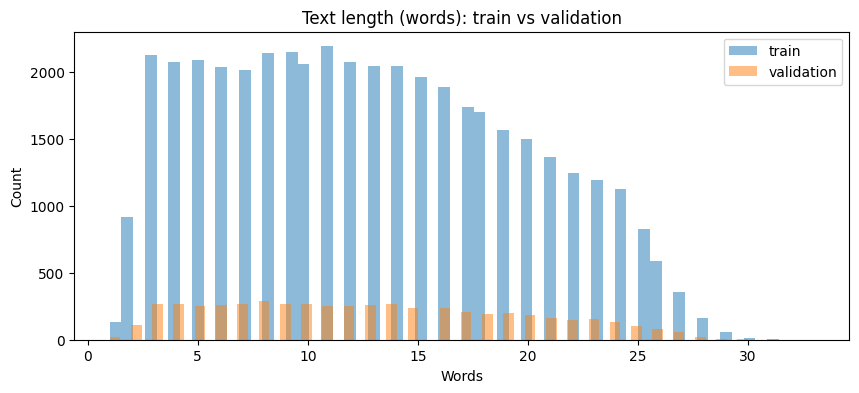

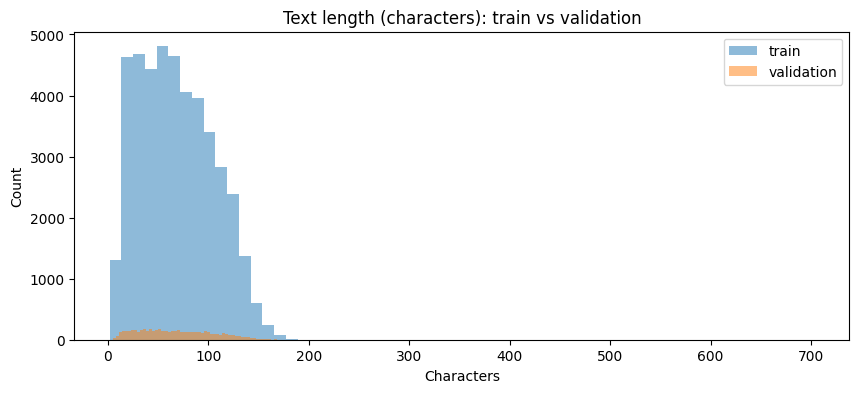

In [12]:
# Compare text lengths between splits
def add_lengths(df):
    df = df.copy()
    df['text_length_words'] = df['text'].astype(str).str.split().apply(len)
    df['text_length_chars'] = df['text'].astype(str).apply(len)
    return df

train_len = add_lengths(train_df)
val_len = add_lengths(val_df)

plt.figure(figsize=(10,4))
plt.hist(train_len['text_length_words'], bins=60, alpha=0.5, label='train')
plt.hist(val_len['text_length_words'], bins=60, alpha=0.5, label='validation')
plt.title("Text length (words): train vs validation")
plt.xlabel("Words")
plt.ylabel("Count")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(train_len['text_length_chars'], bins=60, alpha=0.5, label='train')
plt.hist(val_len['text_length_chars'], bins=60, alpha=0.5, label='validation')
plt.title("Text length (characters): train vs validation")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.legend()
plt.show()


### 3.7) Emotion Co-Occurrence Analysis

Because samples can have multiple labels, understanding **which emotions frequently co-occur** helps interpret model confusions and can motivate:
- correlation-aware thresholds
- label smoothing or graph-based regularisation
- targeted data augmentation for rare pairs


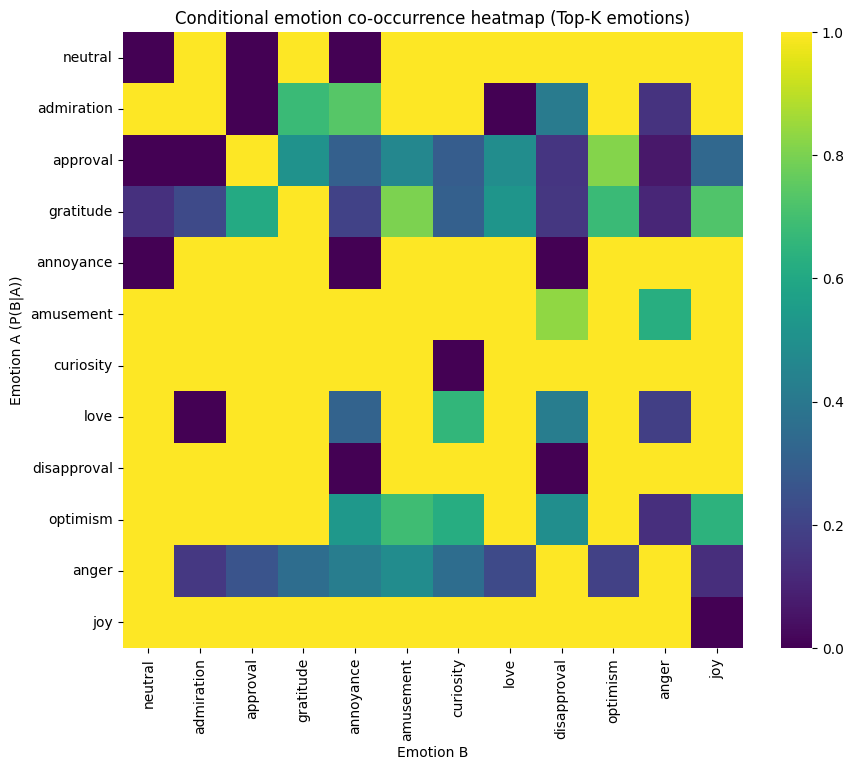

,A,B,P(B|A),count_both
0,joy,admiration,126.0,126
1,curiosity,neutral,118.0,118
2,neutral,curiosity,118.0,118
3,annoyance,disappointment,110.0,110
4,disappointment,annoyance,110.0,110
5,disapproval,neutral,109.0,109
6,neutral,disapproval,109.0,109
7,neutral,confusion,98.0,98
8,neutral,admiration,94.0,94
9,joy,amusement,90.0,90


In [13]:
# Build a multi-hot matrix for co-occurrence
num_classes = len(label_names)
multi_hot = np.zeros((len(train_df), num_classes), dtype=np.int8)

for i, labs in enumerate(train_df['labels']):
    for lid in labs:
        multi_hot[i, lid] = 1

# Co-occurrence matrix: C[a,b] = number of samples containing both a and b
co_mat = multi_hot.T @ multi_hot

# Convert to DataFrame for readability
co_df = pd.DataFrame(co_mat, index=label_names, columns=label_names)

# Normalise by diagonal (how often label appears) -> conditional co-occurrence P(b|a)
diag = np.diag(co_mat).astype(float)
cond = co_mat / np.maximum(diag[:, None], 1.0)
cond_df = pd.DataFrame(cond, index=label_names, columns=label_names)

# Plot: top-left heatmap can be large; consider restricting to top-K frequent emotions
top_k = 12
top_emotions = list(label_series.index[:top_k]) if 'label_series' in globals() else label_names[:top_k]

plt.figure(figsize=(10,8))
sns.heatmap(cond_df.loc[top_emotions, top_emotions], cmap="viridis", vmin=0, vmax=1)
plt.title("Conditional emotion co-occurrence heatmap (Top-K emotions)")
plt.xlabel("Emotion B")
plt.ylabel("Emotion A (P(B|A))")
plt.show()

# Show strongest off-diagonal pairs
pairs = []
for a in range(num_classes):
    for b in range(num_classes):
        if a != b:
            pairs.append((label_names[a], label_names[b], cond[a,b], co_mat[a,b]))
pairs_sorted = sorted(pairs, key=lambda x: (x[2], x[3]), reverse=True)
display(pd.DataFrame(pairs_sorted, columns=["A","B","P(B|A)","count_both"]).head(20))


### 3.8) Token / N-gram Exploration (Global and per emotion)

This section explores **surface-level lexical signals** in the dataset. It does *not* replace contextual modelling, but it helps validate that emotion labels correspond to meaningful text patterns.

We use `CountVectorizer` for simple n-gram statistics.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Basic English tokenisation; you can tune min_df/max_df later
vectorizer = CountVectorizer(stop_words="english", ngram_range=(1,2), min_df=20)

X = vectorizer.fit_transform(train_df['text'].astype(str))
vocab = np.array(vectorizer.get_feature_names_out())
counts = np.asarray(X.sum(axis=0)).ravel()

top_idx = counts.argsort()[::-1][:30]
top_terms = pd.DataFrame({"term": vocab[top_idx], "count": counts[top_idx]})
print("Top n-grams (global):")
display(top_terms)

# Per-emotion top terms (single-label subset to avoid leakage across emotions)
single_df = train_df[train_df['n_labels'] == 1].copy()

def top_terms_for_emotion(emotion_name, k=20):
    # map emotion_name -> id
    eid = label_names.index(emotion_name) if isinstance(label_names, list) else list(label_names).index(emotion_name)
    subset = single_df[single_df['labels'].apply(lambda x: x[0] == eid)]
    if len(subset) < 200:
        return None
    X_sub = vectorizer.transform(subset['text'].astype(str))
    sub_counts = np.asarray(X_sub.sum(axis=0)).ravel()
    idx = sub_counts.argsort()[::-1][:k]
    return pd.DataFrame({"term": vocab[idx], "count": sub_counts[idx]})

# Example: inspect for the most frequent emotions
for emo in (list(label_series.index[:5]) if 'label_series' in globals() else label_names[:5]):
    res = top_terms_for_emotion(emo, k=15)
    if res is not None:
        print(f"\nTop terms for emotion: {emo}")
        display(res)


Top n-grams (global):


,term,count
0,just,3435
1,like,3276
2,don,2109
3,love,1916
4,people,1812
5,good,1730
6,really,1461
7,think,1440
8,know,1428
9,thanks,1281



Top terms for emotion: neutral


,term,count
0,just,1030
1,like,903
2,people,562
3,don,561
4,think,441
5,know,381
6,time,359
7,ve,281
8,got,279
9,way,279



Top terms for emotion: admiration


,term,count
0,great,398
1,good,384
2,like,191
3,awesome,179
4,amazing,177
5,pretty,155
6,nice,152
7,best,151
8,just,134
9,beautiful,117



Top terms for emotion: approval


,term,count
0,like,169
1,just,163
2,agree,132
3,right,127
4,yes,114
5,yeah,113
6,think,95
7,don,90
8,people,81
9,sure,81



Top terms for emotion: gratitude


,term,count
0,thanks,879
1,thank,753
2,ll,114
3,just,108
4,good,97
5,know,79
6,like,64
7,time,57
8,didn,56
9,really,52



Top terms for emotion: annoyance


,term,count
0,just,133
1,like,122
2,don,111
3,people,105
4,stupid,66
5,shit,54
6,time,54
7,damn,48
8,fucking,47
9,fuck,45


### 3.9) Outlier Analysis: Very Long or Very Short Texts

Outliers can dominate training if not handled properly. Here we identify unusually long/short texts and inspect them.


In [16]:
# Identify outliers by word length percentiles
q_low, q_high = train_len['text_length_words'].quantile([0.01, 0.99])
print("1st percentile:", q_low, "99th percentile:", q_high)

short_outliers = train_len[train_len['text_length_words'] <= q_low].head(10)
long_outliers  = train_len[train_len['text_length_words'] >= q_high].head(10)

print("\nShort outliers:")
display(short_outliers[['text','labels','text_length_words']])

print("\nLong outliers:")
display(long_outliers[['text','labels','text_length_words']])




1st percentile: 2.0 99th percentile: 27.0

Short outliers:


,text,labels,text_length_words
17,Fucking coward.,[2],2
28,"Super, thanks",[15],2
53,"Cheers, sololander!",[27],2
65,Awesome. Thanks!,"[0, 15]",2
197,[NAME],[11],1
283,Hi [NAME]!,[27],2
299,"Ah, victory","[17, 26]",2
392,It's embarrassing!,[12],2
413,IT'S MA'AM!!!!,[27],2
497,Brave soul.,[0],2



Long outliers:


,text,labels,text_length_words
46,It's true though. He either gets no shirt and ...,[20],27
88,Sometimes life actually hands you lemons. We'r...,"[4, 22]",27
137,I don't think aspergers causes me distress or ...,[22],28
170,horse meat is fucking peng i love it. why is i...,[18],27
253,Does nobody notice that this is a doctored pho...,[10],27
267,my mom caught be masturbating to dominatrix po...,[1],29
289,Season 2 just started and as a huge TNG fan I ...,[4],28
302,the number 9 recruit from the 2019 class at US...,[1],28
305,Every day it gets harder to tell the differenc...,"[3, 9]",27
350,Thats insane. Someone died like 2 years ago af...,[16],29


### 3.10) Simple Linguistic Features (optional)

These quick features can highlight dataset artefacts (e.g., lots of exclamation marks for excitement). They can also be useful for an ablation baseline.


,n_exclaim,n_question,upper_ratio
count,43410.000000,43410.000000,43410.000000
mean,0.202787,0.123612,0.058854
std,0.635223,0.396217,0.091640
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.020979
50%,0.000000,0.000000,0.035714
75%,0.000000,0.000000,0.063291
max,13.000000,6.000000,1.000000


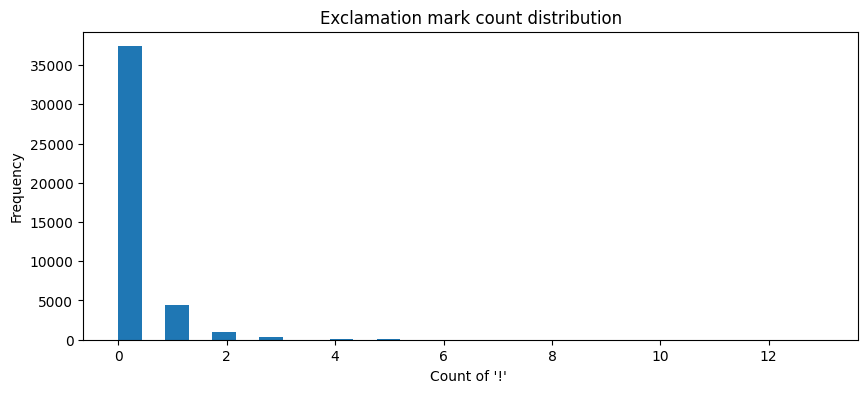

In [18]:
import re

def linguistic_features(df):
    df = df.copy()
    txt = df['text'].astype(str)
    df['n_exclaim'] = txt.str.count('!')
    df['n_question'] = txt.str.count(r'\?')
    df['has_emoji'] = txt.apply(lambda s: bool(re.search(r'[\U0001F300-\U0001FAFF]', s)))
    df['has_url'] = txt.str.contains(r'http[s]?://|www\.', regex=True)
    df['upper_ratio'] = txt.apply(lambda s: sum(ch.isupper() for ch in s) / max(len(s),1))
    return df

feat_df = linguistic_features(train_df)

display(feat_df[['n_exclaim','n_question','has_emoji','has_url','upper_ratio']].describe())

plt.figure(figsize=(10,4))
plt.hist(feat_df['n_exclaim'], bins=30)
plt.title("Exclamation mark count distribution")
plt.xlabel("Count of '!' ")
plt.ylabel("Frequency")
plt.show()


## 4) Data Preprocessing and Tokenization

In [19]:
# Initialize the RoBERTa tokenizer and prepare multi-hot labels.

# Initialize the Tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_CHECKPOINT)

# Helper function to convert list of labels (indices) to a multi-hot vector (float tensor)
def prepare_labels_and_tokenize(examples):
    # 1. Tokenization
    tokenized = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

    # 2. Multi-Hot Label Conversion (CRITICAL FOR MULTI-LABEL)
    multi_hot_labels = []
    for label_list in examples['labels']:
        # Create an array of zeros
        multi_hot = np.zeros(NUM_LABELS, dtype=float)
        # Set indices corresponding to present emotions to 1.0
        multi_hot[label_list] = 1.0
        multi_hot_labels.append(multi_hot.tolist())

    tokenized["labels"] = multi_hot_labels
    return tokenized

# Apply tokenization and label conversion to all splits
tokenized_datasets = raw_datasets.map(
    prepare_labels_and_tokenize,
    batched=True,
    remove_columns=["text", "id"] # Remove original text and id columns
)

# Set the format to PyTorch tensors
# Note: 'labels' must be set to 'torch.float' for multi-label (BCELoss)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"], output_all_columns=False)

print("\nTokenized Dataset Structure:")
print(tokenized_datasets)
print("\nExample Multi-Hot Label (Expected 28 floats, mostly zeros):")
print(tokenized_datasets['train'][0]['labels'])


Tokenized Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5427
    })
})

Example Multi-Hot Label (Expected 28 floats, mostly zeros):
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1])


## 5) Model Building and Training Setup

### 5.1) Initialize and load the pre-trained RoBERTa model for sequence classification

In [20]:
# Load the pre-trained RoBERTa model for sequence classification.

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=NUM_LABELS,
    # Crucial argument for multi-label tasks: applies sigmoid and uses BCEWithLogitsLoss
    problem_type="multi_label_classification"
)

# Move model to the detected device (GPU)
model.to(device)

print(f"Model {MODEL_CHECKPOINT} initialized for multi-label classification ({NUM_LABELS} classes) and moved to {device}.")

# Enable gradient checkpointing to save memory and allow longer sequences
try:
    model.gradient_checkpointing_enable()
    if hasattr(model.config, 'use_cache'):
        model.config.use_cache = False
    print('Gradient checkpointing enabled.')
except Exception as e:
    print('Could not enable gradient checkpointing:', e)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model roberta-base initialized for multi-label classification (28 classes) and moved to cuda.
Gradient checkpointing enabled.


### 5.2) Define Multi-Label Metrics Function

In [24]:
# Define Multi-Label Metrics Function
# Includes common multi-label metrics used in reporting (micro/macro precision/recall/F1,
# exact match ratio, hamming loss/accuracy, and Jaccard).

def compute_metrics(eval_pred):
    """Compute metrics for multi-label classification (sigmoid + threshold).
   
    Returns keys compatible with Hugging Face Trainer (they'll be prefixed with eval_/test_).
    """
    logits, labels = eval_pred
    # Apply sigmoid to logits to get probabilities
    probs = 1 / (1 + np.exp(-logits))
    # Default threshold (tuned thresholds are handled later in the notebook)
    preds = (probs >= 0.5).astype(int)

    # Core F1 scores
    f1_micro = f1_score(labels, preds, average='micro', zero_division=0)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)
    f1_samples = f1_score(labels, preds, average='samples', zero_division=0)

    # Precision / recall
    precision_micro = precision_score(labels, preds, average='micro', zero_division=0)
    recall_micro = recall_score(labels, preds, average='micro', zero_division=0)
    precision_macro = precision_score(labels, preds, average='macro', zero_division=0)
    recall_macro = recall_score(labels, preds, average='macro', zero_division=0)

    # Exact Match Ratio (subset accuracy): strict per-sample match
    exact_match_ratio = (labels == preds).all(axis=1).mean()

    # Hamming loss / accuracy (label-wise)
    h_loss = hamming_loss(labels, preds)
    h_acc = 1.0 - h_loss

    # Jaccard index for multi-label (samples average is common)
    jaccard_samples = jaccard_score(labels, preds, average='samples', zero_division=0)

    # Optional: ranking-style metrics on probabilities (can be useful for reports)
    # These can fail if a class has only one label value in the eval split; guard gracefully.
    try:
        roc_auc_micro = roc_auc_score(labels, probs, average='micro')
    except Exception:
        roc_auc_micro = float('nan')
    try:
        pr_auc_micro = average_precision_score(labels, probs, average='micro')
    except Exception:
        pr_auc_micro = float('nan')

    return {
        'f1_micro': float(f1_micro),
        'f1_macro': float(f1_macro),
        'f1_samples': float(f1_samples),
        'precision_micro': float(precision_micro),
        'recall_micro': float(recall_micro),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro),
        'exact_match_ratio': float(exact_match_ratio),
        'hamming_loss': float(h_loss),
        'accuracy_hamming': float(h_acc),
        'jaccard_samples': float(jaccard_samples),
        'roc_auc_micro': float(roc_auc_micro),
        'pr_auc_micro': float(pr_auc_micro),
    }

### 5.3) Define Training Arguments and Trainer

In [ ]:
# Define Training Arguments and Trainer
# Fallback: Removed unsupported keyword arguments (evaluation_strategy, save_strategy,
# load_best_model_at_end, metric_for_best_model) to be compatible with the current

training_args = TrainingArguments(
    output_dir="./training_go_emotions_results",      # Output directory for checkpoints and predictions
    num_train_epochs=12,                              # More epochs for better convergence
    per_device_train_batch_size=8,                    # Smaller per-device batch
    gradient_accumulation_steps=4,                    # Effective batch size 32
    per_device_eval_batch_size=64,                    # Evaluation batch size
    learning_rate=2e-5,                               # More stable LR for RoBERTa-base
    warmup_steps=500,                                 # LR scheduler warmup
    weight_decay=0.01,                                # Weight decay
    logging_dir='./training_go_emotions_logs',         # TensorBoard logs dir
    logging_steps=100,
    fp16=True,                                        # Mixed precision (if supported)
    do_eval=True                                      # Ensure evaluation capability
)

# Initialize the Trainer (evaluation will be triggered manually after training)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer initialized without strategy arguments. You can run trainer.train() then trainer.evaluate().")


Trainer initialized without strategy arguments. You can run trainer.train() then trainer.evaluate().


### 5.4) Compute class imbalance weights and loss shaping options

In [26]:
# pos_weight: balances positive vs negative examples per label in BCEWithLogitsLoss
# focal loss: focuses learning on hard examples (enabled after hyperparam search)
# label smoothing disabled (best trial showed smoothing=0.0)

import numpy as np
import torch

# Class-wise positive counts from training labels
label_counts = np.zeros(NUM_LABELS, dtype=np.int64)
for label_list in train_df['labels']:
    for idx in label_list:
        label_counts[idx] += 1

num_samples = len(train_df)
neg_counts = num_samples - label_counts
# Avoid division by zero; clamp pos counts to at least 1
pos_weight_np = np.where(label_counts > 0, neg_counts / label_counts, 1.0)
# Prevent extreme weights that can destabilize training
pos_weight_np = np.clip(pos_weight_np, 1.0, 10.0)

pos_weight = torch.tensor(pos_weight_np, dtype=torch.float32, device=device)

# Adopt best trial hyperparams
LABEL_SMOOTHING = 0.0  # disabled per best trial
USE_FOCAL = True       # focal enabled
FOCAL_GAMMA = 1.5

print("pos_weight prepared. min/max:", float(pos_weight.min().item()), float(pos_weight.max().item()))
print(f"Hyperparams adopted: smoothing={LABEL_SMOOTHING}, focal={USE_FOCAL}, gamma={FOCAL_GAMMA}")

pos_weight prepared. min/max: 2.05295729637146 10.0
Hyperparams adopted: smoothing=0.0, focal=True, gamma=1.5


## 6) Model Training

In [ ]:
# Model Training
print("Starting model fine-tuning...")

# Ensure labels are float32 tensors for BCEWithLogitsLoss
for split in tokenized_datasets.keys():
	tokenized_datasets[split] = tokenized_datasets[split].map(
		lambda batch: {
			"labels": [np.asarray(vec, dtype=np.float32).tolist() for vec in batch["labels"]]
		},
		batched=True
	)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Ensure training flag is enabled
training_args.do_train = True

# Use a custom Trainer to force BCEWithLogitsLoss with pos_weight, label smoothing, and optional focal scaling
import torch.nn.functional as F

class MultiLabelTrainer(Trainer):
	def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
		labels = inputs.pop("labels")
		outputs = model(**inputs)
		logits = outputs.logits
		# Match labels dtype to logits dtype (handles fp16 automatically)
		if labels.dtype != logits.dtype:
			labels = labels.to(logits.dtype)

		# Label smoothing for multilabel: y_s = y*(1-eps) + (1-y)*eps
		eps = float(LABEL_SMOOTHING) if 'LABEL_SMOOTHING' in globals() else 0.0
		if eps > 0:
			labels_smooth = labels * (1.0 - eps) + (1.0 - labels) * eps
		else:
			labels_smooth = labels

		# Prepare class-wise pos_weight
		pw = pos_weight.to(dtype=logits.dtype, device=logits.device) if 'pos_weight' in globals() else None

		# Base BCE with logits (no reduction for optional focal modulation)
		bce = torch.nn.BCEWithLogitsLoss(pos_weight=pw, reduction='none') if pw is not None else torch.nn.BCEWithLogitsLoss(reduction='none')
		loss_matrix = bce(logits, labels_smooth)

		# Optional focal loss modulation
		use_focal = bool(USE_FOCAL) if 'USE_FOCAL' in globals() else False
		if use_focal:
			gamma = float(FOCAL_GAMMA) if 'FOCAL_GAMMA' in globals() else 1.5
			with torch.no_grad():
				p = torch.sigmoid(logits)
				p_t = p * labels + (1.0 - p) * (1.0 - labels)  # use original labels for focal term
			loss_matrix = loss_matrix * ((1.0 - p_t) ** gamma)

		loss = loss_matrix.mean()
		return (loss, outputs) if return_outputs else loss

# Reinitialize the trainer to use the custom loss
trainer = MultiLabelTrainer(
	model=model,
	args=training_args,
	train_dataset=tokenized_datasets["train"],
	eval_dataset=tokenized_datasets["validation"],
	processing_class=tokenizer,
	compute_metrics=compute_metrics,
)

# The trainer will automatically use the GPU
train_result = trainer.train()

print("\nTraining complete!")
# Log the training metrics
metrics = train_result.metrics
trainer.log_metrics("train", metrics)

Starting model fine-tuning...


Step,Training Loss
100,0.305600
200,0.239600
300,0.199900
400,0.165300
500,0.151800
600,0.142100
700,0.138400
800,0.135200
900,0.129900
1000,0.124800



Training complete!
***** train metrics *****
  epoch                    =       12.0
  total_flos               = 39898966GF
  train_loss               =     0.0689
  train_runtime            = 1:45:09.15
  train_samples_per_second =     82.566
  train_steps_per_second   =      2.581


## 7) Model Evaluation and Testing

Starting evaluation on the Test set...


***** test metrics *****
  test_accuracy_hamming   =     0.9546
  test_exact_match_ratio  =     0.3287
  test_f1_macro           =      0.505
  test_f1_micro           =     0.5569
  test_f1_samples         =     0.5833
  test_hamming_loss       =     0.0454
  test_jaccard_samples    =     0.5151
  test_loss               =     0.1674
  test_pr_auc_micro       =     0.5929
  test_precision_macro    =     0.4231
  test_precision_micro    =     0.4695
  test_recall_macro       =     0.6453
  test_recall_micro       =     0.6843
  test_roc_auc_micro      =     0.9481
  test_runtime            = 0:00:10.50
  test_samples_per_second =    516.512
  test_steps_per_second   =       8.09

=== Test Metrics (all) ===
test_accuracy_hamming: 0.954645
test_exact_match_ratio: 0.328727
test_f1_macro: 0.504979
test_f1_micro: 0.556899
test_f1_samples: 0.583283
test_hamming_loss: 0.045355
test_jaccard_samples: 0.515134
test_loss: 0.167448
test_pr_auc_micro: 0.592949
test_precision_macro: 0.423126
test_pr

,pred_0,pred_1
true_0,140733,4894
true_1,1998,4331


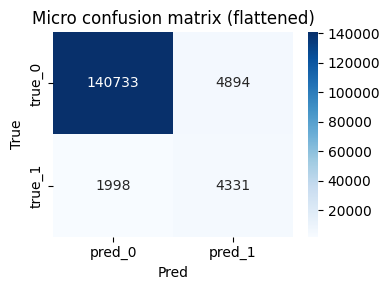


=== Per-label confusion (TN/FP/FN/TP) ===


,label,tn,fp,fn,tp,support_pos
27,neutral,2973,667,597,1190,1787
0,admiration,4594,329,91,413,504
15,gratitude,4999,76,22,330,352
4,approval,4643,433,163,188,351
3,annoyance,4618,489,134,186,320
7,curiosity,4842,301,51,233,284
10,disapproval,4847,313,118,149,267
1,amusement,5057,106,20,244,264
18,love,5081,108,19,219,238
2,anger,5016,213,69,129,198


In [31]:
# Model Evaluation and Testing

print("Starting evaluation on the Test set...")

# Predict logits on the test set
predictions = trainer.predict(tokenized_datasets["test"])

# Extract metrics
test_metrics = predictions.metrics
trainer.log_metrics("test", test_metrics)

# Print ALL metrics returned by Trainer.predict()
def _fmt_metric_value(v):
    try:
        # handle numpy scalars cleanly
        if isinstance(v, (np.floating, float)):
            if np.isnan(v):
                return "nan"
            return f"{float(v):.6f}"
        if isinstance(v, (np.integer, int)):
            return str(int(v))
    except Exception:
        pass
    return str(v)

print("\n=== Test Metrics (all) ===")
for k in sorted(test_metrics.keys()):
    print(f"{k}: {_fmt_metric_value(test_metrics[k])}")

# --- Confusion matrix (multi-label) ---
# For multi-label classification there is no single NxN confusion matrix.
# Instead, we provide:
# 1) A micro (flattened) 2x2 confusion matrix across all label decisions
# 2) Per-label 2x2 confusion matrices (TN/FP/FN/TP)
from IPython.display import display

test_logits = predictions.predictions
test_labels = predictions.label_ids
test_probs = 1 / (1 + np.exp(-test_logits))
test_preds = (test_probs >= 0.5).astype(int)

print("\n=== Confusion Matrix (micro, flattened over all labels) ===")
cm_micro = confusion_matrix(test_labels.reshape(-1), test_preds.reshape(-1), labels=[0, 1])
cm_micro_df = pd.DataFrame(cm_micro, index=["true_0", "true_1"], columns=["pred_0", "pred_1"])
display(cm_micro_df)

# Optional heatmap visualization
plt.figure(figsize=(4, 3))
sns.heatmap(cm_micro_df, annot=True, fmt="d", cmap="Blues")
plt.title("Micro confusion matrix (flattened)")
plt.ylabel("True")
plt.xlabel("Pred")
plt.tight_layout()
plt.show()

print("\n=== Per-label confusion (TN/FP/FN/TP) ===")
rows = []
for i, name in enumerate(label_names):
    cm_i = confusion_matrix(test_labels[:, i], test_preds[:, i], labels=[0, 1])
    tn, fp, fn, tp = cm_i.ravel()
    rows.append({
        "label": name,
        "tn": int(tn),
        "fp": int(fp),
        "fn": int(fn),
        "tp": int(tp),
        "support_pos": int(test_labels[:, i].sum()),
    })

per_label_df = pd.DataFrame(rows).sort_values(["support_pos", "label"], ascending=[False, True])
display(per_label_df.head(15))

## 8) Threshold Tuning on Validation Set

In [32]:
# Threshold Tuning on Validation Set
# We search for a single global threshold and per-class thresholds that maximize micro F1.

import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# Get validation predictions (logits)
val_outputs = trainer.predict(tokenized_datasets['validation'])
val_logits = val_outputs.predictions
val_labels = val_outputs.label_ids
val_probs = 1 / (1 + np.exp(-val_logits))

# Search global threshold
candidate_thresholds = np.linspace(0.05, 0.95, 19)
best_global_f1 = -1.0
best_global_th = 0.5
for th in candidate_thresholds:
    preds = (val_probs >= th).astype(int)
    f1 = f1_score(val_labels, preds, average='micro')
    if f1 > best_global_f1:
        best_global_f1 = f1
        best_global_th = th

print(f"Best Global Threshold: {best_global_th:.3f} (Micro F1={best_global_f1:.4f})")

# Per-class threshold search
per_class_thresholds = []
for c in range(NUM_LABELS):
    best_f1_c = -1.0
    best_th_c = 0.5
    for th in candidate_thresholds:
        preds_c = (val_probs[:, c] >= th).astype(int)
        f1_c = f1_score(val_labels[:, c], preds_c, average='binary', zero_division=0)
        if f1_c > best_f1_c:
            best_f1_c = f1_c
            best_th_c = th
    per_class_thresholds.append(best_th_c)

print("Per-class thresholds (length = NUM_LABELS):")
print(per_class_thresholds)

# Choose strategy: per-class if it improves overall micro F1 when applied
per_class_preds = (val_probs >= np.array(per_class_thresholds)).astype(int)
per_class_micro_f1 = f1_score(val_labels, per_class_preds, average='micro')
print(f"Per-Class Threshold Micro F1 on validation: {per_class_micro_f1:.4f}")

USE_PER_CLASS = per_class_micro_f1 > best_global_f1
print("Using per-class thresholds?", USE_PER_CLASS)

# Persist chosen thresholds
chosen_thresholds = per_class_thresholds if USE_PER_CLASS else [best_global_th] * NUM_LABELS


Best Global Threshold: 0.550 (Micro F1=0.5706)
Per-class thresholds (length = NUM_LABELS):
[np.float64(0.65), np.float64(0.7), np.float64(0.7999999999999999), np.float64(0.5499999999999999), np.float64(0.5499999999999999), np.float64(0.65), np.float64(0.6), np.float64(0.44999999999999996), np.float64(0.6), np.float64(0.5499999999999999), np.float64(0.5499999999999999), np.float64(0.7999999999999999), np.float64(0.65), np.float64(0.65), np.float64(0.44999999999999996), np.float64(0.7999999999999999), np.float64(0.5499999999999999), np.float64(0.6), np.float64(0.65), np.float64(0.65), np.float64(0.75), np.float64(0.7), np.float64(0.7), np.float64(0.39999999999999997), np.float64(0.65), np.float64(0.7999999999999999), np.float64(0.65), np.float64(0.39999999999999997)]
Per-Class Threshold Micro F1 on validation: 0.5943
Using per-class thresholds? True


## 9) Final Test Evaluation with Tuned Thresholds

In [33]:
# Final Test Evaluation with Tuned Thresholds
from sklearn.metrics import f1_score

# Predict on test set
test_outputs = trainer.predict(tokenized_datasets['test'])
test_logits = test_outputs.predictions
test_labels = test_outputs.label_ids
test_probs = 1 / (1 + np.exp(-test_logits))

# Helper to compute multi-label metrics for a given threshold vector
import numpy as np

def metrics_with_thresholds(probs, labels, thresholds):
    ths = np.array(thresholds, dtype=float)
    preds = (probs >= ths).astype(int)
    micro_f1 = f1_score(labels, preds, average='micro')
    exact_match = (preds == labels).all(axis=1).mean()
    hamming_acc = (preds == labels).mean()
    macro_acc = (preds == labels).mean(axis=0).mean()
    return micro_f1, exact_match, hamming_acc, macro_acc

# Baseline 0.5 for comparison
baseline_metrics = metrics_with_thresholds(test_probs, test_labels, [0.5] * NUM_LABELS)
print(f"Baseline (0.5) — Micro F1: {baseline_metrics[0]:.4f} | Exact Match: {baseline_metrics[1]:.4f} | Hamming Acc: {baseline_metrics[2]:.4f} | Macro Acc: {baseline_metrics[3]:.4f}")

# Tuned thresholds
tuned_metrics = metrics_with_thresholds(test_probs, test_labels, chosen_thresholds)
print(f"Tuned thresholds — Micro F1: {tuned_metrics[0]:.4f} | Exact Match: {tuned_metrics[1]:.4f} | Hamming Acc: {tuned_metrics[2]:.4f} | Macro Acc: {tuned_metrics[3]:.4f}")

# Optional: quick per-class F1 on top-10 frequent labels for visibility
from collections import Counter
label_freq = Counter([idx for lst in train_df['labels'] for idx in lst])
most_common = [i for i, _ in label_freq.most_common(10)]
print("\nTop-10 labels (by train frequency) — per-class F1 with tuned thresholds:")
for i in most_common:
    preds_i = (test_probs[:, i] >= chosen_thresholds[i]).astype(int)
    f1_i = f1_score(test_labels[:, i], preds_i, average='binary', zero_division=0)
    print(f"  {label_names[i]}: {f1_i:.3f}")


Baseline (0.5) — Micro F1: 0.5569 | Exact Match: 0.3287 | Hamming Acc: 0.9546 | Macro Acc: 0.9546
Tuned thresholds — Micro F1: 0.5796 | Exact Match: 0.3702 | Hamming Acc: 0.9600 | Macro Acc: 0.9600

Top-10 labels (by train frequency) — per-class F1 with tuned thresholds:
  neutral: 0.668
  admiration: 0.676
  approval: 0.385
  gratitude: 0.912
  annoyance: 0.366
  amusement: 0.808
  curiosity: 0.561
  love: 0.795
  disapproval: 0.415
  optimism: 0.519


## 10) Lightweight Hyperparameter Search (Validation Micro F1)

In [34]:
# Lightweight Hyperparameter Search (Validation Micro F1)
# This runs a few short training passes (1 epoch) to select lr / smoothing / focal usage.

from copy import deepcopy
from math import ceil

search_space = [
    {"learning_rate": 2e-5, "label_smoothing": 0.00, "use_focal": False},
    {"learning_rate": 2e-5, "label_smoothing": 0.05, "use_focal": False},
    {"learning_rate": 1e-5, "label_smoothing": 0.05, "use_focal": False},
    {"learning_rate": 2e-5, "label_smoothing": 0.00, "use_focal": True},
]

short_results = []
orig_epochs = training_args.num_train_epochs
training_args.num_train_epochs = 1  # short runs

for cfg in search_space:
    print(f"\nTrial: lr={cfg['learning_rate']} smoothing={cfg['label_smoothing']} focal={cfg['use_focal']}")
    # Update global toggles
    LABEL_SMOOTHING = cfg['label_smoothing']
    USE_FOCAL = cfg['use_focal']
    # Rebuild trainer to pick up new loss behavior
    trial_trainer = MultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets['train'].select(range(min(1500, len(tokenized_datasets['train'])))),  # subset for speed
        eval_dataset=tokenized_datasets['validation'],
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
    )
    trial_trainer.args.learning_rate = cfg['learning_rate']
    trial_trainer.train()
    eval_metrics = trial_trainer.evaluate(tokenized_datasets['validation'])
    micro_f1 = eval_metrics.get('eval_f1_micro') or eval_metrics.get('f1_micro')
    short_results.append({**cfg, 'micro_f1': micro_f1})
    print(f"Validation micro F1: {micro_f1:.4f}")

# Restore epochs
training_args.num_train_epochs = orig_epochs

best_cfg = max(short_results, key=lambda x: x['micro_f1'])
print("\nBest trial:", best_cfg)
# Apply best to globals
LABEL_SMOOTHING = best_cfg['label_smoothing']
USE_FOCAL = best_cfg['use_focal']
trainer.args.learning_rate = best_cfg['learning_rate']





Trial: lr=2e-05 smoothing=0.0 focal=False


Step,Training Loss


Validation micro F1: 0.5621

Trial: lr=2e-05 smoothing=0.05 focal=False


Step,Training Loss


Validation micro F1: 0.4415

Trial: lr=1e-05 smoothing=0.05 focal=False


Step,Training Loss


Validation micro F1: 0.3747

Trial: lr=2e-05 smoothing=0.0 focal=True


Step,Training Loss


Validation micro F1: 0.5092

Best trial: {'learning_rate': 2e-05, 'label_smoothing': 0.0, 'use_focal': False, 'micro_f1': 0.5620832010161956}


## 11) Export Model & Thresholds

In [35]:
# Export Model & Thresholds
import json
from pathlib import Path

EXPORT_DIR = Path("./models/text_emotions_model")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print("Saving model...")
trainer.save_model(EXPORT_DIR.as_posix())
print("Saving tokenizer...")
tokenizer.save_pretrained(EXPORT_DIR.as_posix())

thresholds_path = EXPORT_DIR / "chosen_thresholds.json"
with open(thresholds_path, 'w') as f:
    json.dump({"thresholds": chosen_thresholds, "strategy": "per_class" if USE_PER_CLASS else "global"}, f, indent=2)
print(f"Thresholds saved to {thresholds_path}")

print("Export complete.")


Saving model...
Saving tokenizer...
Thresholds saved to models\text_emotions_model\chosen_thresholds.json
Export complete.


## 12) ONNX Export & Verification

In [36]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# === paths ===
EXPORT_DIR = Path("./models/text_emotions_model")   # same folder you used for trainer.save_model
ONNX_PATH = EXPORT_DIR / "text_emotion.onnx"

# Must match the max_length you used during training
MAX_LEN = 128  # or 200, etc. Set this to the same value as in your training code

print("Loading fine-tuned model from:", EXPORT_DIR)

model = AutoModelForSequenceClassification.from_pretrained(EXPORT_DIR.as_posix())
tokenizer = AutoTokenizer.from_pretrained(EXPORT_DIR.as_posix(), use_fast=True)

model.eval()
model.cpu()   # ONNX export from CPU

# Dummy input with correct shape
dummy_inputs = tokenizer(
    "This is a dummy input for ONNX export.",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=MAX_LEN,
)

input_ids      = dummy_inputs["input_ids"]
attention_mask = dummy_inputs["attention_mask"]

os.makedirs(EXPORT_DIR, exist_ok=True)

print("Exporting to ONNX:", ONNX_PATH)

torch.onnx.export(
    model,
    (input_ids, attention_mask),
    ONNX_PATH.as_posix(),
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch", 1: "sequence"},
        "attention_mask": {0: "batch", 1: "sequence"},
        "logits": {0: "batch"},
    },
    opset_version=17,  # good modern opset
)

print("ONNX export complete.")
print("Saved file:", ONNX_PATH)


Loading fine-tuned model from: models\text_emotions_model
Exporting to ONNX: models\text_emotions_model\text_emotion.onnx


c:\Users\Public\Documents\Emotion-recognition-dissertation\App\backend\venv\Lib\site-packages\transformers\modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


ONNX export complete.
Saved file: models\text_emotions_model\text_emotion.onnx
